## Setup autoreload, warnings and helper functions

In [161]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [162]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports

In [163]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice, SequenceDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step, read_image
from sql import get_db_ids
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_sequence_dataset
from reidentification.visualisation import visualise_match
from simple_database import SimpleDatabase, DBDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [164]:
cfg = config()


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Download the dataset

In [238]:
cfg["dataset_dir"] = "/ekaterina/work/data/many_dataset/pattern"
dataset_dir = Path(cfg["dataset_dir"])

if not dataset_dir.exists():
    
    print("Download and extract dataset")
    # Get a single use download link from https://etsin.fairdata.fi/dataset/22b5191e-f24b-4457-93d3-95797c900fc0/data
    # You will only need "full images.zip" for the reidentification, generate a link to that.
    dataset_url = ""
    
    print(f'Creating directory "{dataset_dir}"')
    dataset_dir.mkdir(parents=True, exist_ok=True)
    
    file = wget.download(dataset_url.replace(" ", "%20"), out=str(dataset_dir))
    print()
    print(f'Extracting "{file}"')
    zip_f = zipfile.ZipFile(file, 'r')
    zip_f.extractall(dataset_dir)
    zip_f.close()
    Path(file).unlink()

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [239]:
dataset_dir = Path(cfg["dataset_dir"])

pattern_query_dataset = SequenceDataset(dataset_dir)

# sequence_ids = pattern_query_dataset.get_sequence_ids()
# print(len(sequence_ids))
# sequence_data = pattern_query_dataset[4]
# print(sequence_data)


labels = pattern_query_dataset.get_sequence_labels()
print(labels)

['phs103', 'phs103', 'phs097', 'phs081', 'phs097', 'phs087', 'phs127', 'phs125', 'phs125', 'phs100', 'phs100', 'phs100', 'phs091', 'phs091', 'phs116', 'phs116', 'phs116', 'phs115', 'phs115', 'phs087', 'phs170', 'phs170', 'phs167', 'phs116', 'phs188', 'phs164', 'phs087', 'phs087', 'phs125', 'phs109', 'phs109', 'phs174', 'phs164', 'phs176', 'phs103', 'phs103', 'phs101', 'phs101', 'phs101', 'phs021', 'phs021', 'phs127', 'phs116', 'phs188', 'phs097', 'phs164', 'phs034', 'phs034', 'phs034', 'phs010', 'phs010', 'phs010', 'phs010', 'phs093', 'phs093', 'phs093', 'phs093', 'phs028', 'phs028', 'phs164', 'phs116', 'phs023', 'phs023', 'phs023', 'phs176', 'phs176', 'phs082', 'phs167', 'phs082', 'phs028', 'phs028', 'phs087', 'phs174', 'phs174', 'phs021', 'phs034', 'phs034', 'phs034', 'phs093', 'phs087', 'phs087', 'phs091', 'phs091', 'phs026', 'phs026', 'phs026', 'phs021', 'phs021', 'phs021', 'phs021', 'phs034', 'phs034', 'phs034', 'phs034', 'phs023', 'phs026', 'phs022', 'phs022', 'phs034', 'phs021',

## Show an image from the dataset

# Input image

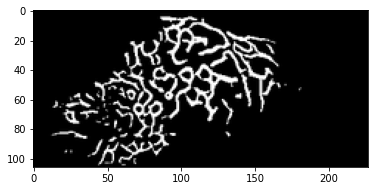

In [240]:
image, label = sequence_data[3]

print_heading("Input image")
plt.imshow(image)
plt.show()

## Apply tonemapping

## Segment and crop an image

## Extract pattern from an image

## Encode an image

In [241]:
encoded_sequence = encode_sequence_dataset(pattern_query_dataset, cfg)
print(len(encoded_sequence))
print("Encoded sequence")

  0%|                                                 | 0/33184 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|██████████████████████████████████| 33184/33184 [12:16:52<00:00,  1.33s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
132
Encoded sequence


1
2
3
0


## Create a small database for testing
This example uses a very simple database implemented as a Python class. The database might take a lot of space if all images are used, and in that case it is better to store it on a disc, e.g. with the help of SQL based database systems.

In [242]:
db_database = DBDatabase("norppa", cfg["conn"], cfg)

# print(len(db_database.get_ids()))
# print(db_database.get_ids()[5])
# print(len(db_database.get_fisher_vectors()))



## Perform re-identification

In [243]:
result = identify(encoded_sequence, db_database, cfg)

print(result)

['phs103', 'phs103', 'phs097', 'phs081', 'phs097', 'phs087', 'phs127', 'phs125', 'phs125', 'phs100', 'phs100', 'phs100', 'phs091', 'phs091', 'phs116', 'phs116', 'phs116', 'phs115', 'phs115', 'phs087', 'phs170', 'phs170', 'phs167', 'phs116', 'phs188', 'phs164', 'phs087', 'phs087', 'phs125', 'phs109', 'phs109', 'phs174', 'phs164', 'phs176', 'phs103', 'phs103', 'phs101', 'phs101', 'phs101', 'phs021', 'phs021', 'phs127', 'phs116', 'phs188', 'phs097', 'phs164', 'phs034', 'phs034', 'phs034', 'phs010', 'phs010', 'phs010', 'phs010', 'phs093', 'phs093', 'phs093', 'phs093', 'phs028', 'phs028', 'phs164', 'phs116', 'phs023', 'phs023', 'phs023', 'phs176', 'phs176', 'phs082', 'phs167', 'phs082', 'phs028', 'phs028', 'phs087', 'phs174', 'phs174', 'phs021', 'phs034', 'phs034', 'phs034', 'phs093', 'phs087', 'phs087', 'phs091', 'phs091', 'phs026', 'phs026', 'phs026', 'phs021', 'phs021', 'phs021', 'phs021', 'phs034', 'phs034', 'phs034', 'phs034', 'phs023', 'phs026', 'phs022', 'phs022', 'phs034', 'phs021',

100%|█████████████████████████████████████████| 132/132 [01:12<00:00,  1.81it/s]

[([{'db_label': ('phs087',), 'distance': 0.06594424301902047}, {'db_label': ('phs125',), 'distance': 0.06794715362714998}, {'db_label': ('phs023',), 'distance': 0.06855988418597969}, {'db_label': ('phs022',), 'distance': 0.06878228069617631}, {'db_label': ('phs160',), 'distance': 0.06990969416022896}], 'phs103'), ([{'db_label': ('phs141',), 'distance': 0.06681359544162624}, {'db_label': ('phs097',), 'distance': 0.06684337911797833}, {'db_label': ('phs116',), 'distance': 0.06722288813321076}, {'db_label': ('phs076',), 'distance': 0.06784676274635171}, {'db_label': ('phs045',), 'distance': 0.06887862522113353}], 'phs103'), ([{'db_label': ('phs127',), 'distance': 0.07508105030971346}, {'db_label': ('phs116',), 'distance': 0.07766578527485046}, {'db_label': ('phs176',), 'distance': 0.07852797422853797}, {'db_label': ('phs082',), 'distance': 0.07887583277149013}, {'db_label': ('phs051',), 'distance': 0.0789503634828076}], 'phs097'), ([{'db_label': ('phs087',), 'distance': 0.0606178910422009

In [244]:
db_labels = np.array([[x['db_label'][0] for x in y[0]] for y in result])
q_labels = np.array(pattern_query_dataset.get_sequence_labels())

topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])
        
    

[0.015151515151515152, 0.06818181818181818, 0.08333333333333333, 0.09848484848484848, 0.11363636363636363]


In [181]:
 get_topk_acc(labels, labels_db, indices, 5)

[([{'db_label': ('phs093',), 'distance': 0.08258875708600233}, {'db_label': ('phs044',), 'distance': 0.0844678597665185}, {'db_label': ('phs001',), 'distance': 0.08488618099778}, {'db_label': ('phs010',), 'distance': 0.08504820847906402}, {'db_label': ('phs104',), 'distance': 0.085248723125672}], {'class_id': 'phs010', 'sequence_id': 'K9_suurvehko_040612_phs010', 'dataset_dir': PosixPath('/ekaterina/work/data/many_dataset/pattern_small')}), ([{'db_label': ('phs211',), 'distance': 0.08518199607124555}, {'db_label': ('phs001',), 'distance': 0.0859984665297745}, {'db_label': ('phs081',), 'distance': 0.08798424006438255}, {'db_label': ('phs116',), 'distance': 0.08927183876231681}, {'db_label': ('phs151',), 'distance': 0.08961100261870392}], {'class_id': 'phs010', 'sequence_id': 'K9_suurvehko_040612_phs010', 'dataset_dir': PosixPath('/ekaterina/work/data/many_dataset/pattern_small')}), ([{'db_label': ('phs045',), 'distance': 0.08972574542241363}, {'db_label': ('phs087',), 'distance': 0.0909

## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
print()

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()